In [1]:
from dataclasses import dataclass
from IPython.core.debugger import set_trace

import numpy as np
from numpy.random import default_rng
from numpy.linalg import inv, norm, det
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.integrate import dblquad
from functools import lru_cache

np.seterr('warn')
np.set_printoptions(precision=6)

In [2]:
def pshape(arr):
    print(arr.shape)

def mse(a,b):
    assert(len(a.shape)==1) # ensure 1 dim vector
    assert(len(b.shape)==1) # ensure 1 dim vector
    
    return np.mean((a-b)**2)

In [3]:
@dataclass
class Parameters:
    n: int = 10000
    A: int = 2
    B: int = 2
    alpha: float = 1
    seed: int = 19
    rng: any = default_rng(seed)
    
    t_mean: any = np.zeros(A)
    t_cov: any = np.eye(A)
        
    r_mean: any = np.zeros(B)
    r_cov: any = np.eye(B)
    
    nu_mean: any = rng.uniform(low=1, high=10, size=A)
    #nu_cov_diag: any = rng.uniform(size=A)
    nu_cov_diag: any = rng.uniform() * np.ones((A))
    nu_cov_diag_inv: any = np.diag(inv(np.diag(nu_cov_diag)))
        
    gamma_mean: any = rng.uniform(low=1, high=10, size=B)
    #gamma_cov_diag: any = rng.uniform(size=B)
    gamma_cov_diag: any = rng.uniform() * np.ones((B))
    gamma_cov_diag_inv: any = np.diag(inv(np.diag(gamma_cov_diag)))
        
    epsilon_mean: any = np.array(0.0)
    epsilon_var: any = rng.uniform()

    epsilon_val: any = np.zeros((n))

In [4]:
def generate_data(params, seed=14560):
    #------- Sample from relevant densities ---------------
    rng = default_rng(seed) # pass seed value to default random number generator
    nu = rng.multivariate_normal(params.nu_mean, np.diag(params.nu_cov_diag)) # sample nu from multivariate normal w/ diagonal covar matrix
    gamma = rng.multivariate_normal(params.gamma_mean, np.diag(params.gamma_cov_diag)) # sample gamma from multivariate normal w/ diagonal covar matrix
    assert(gamma.any() != 0) # Some element of gamma must not == 0, otherwise there's no misspecification
    t = rng.multivariate_normal(params.t_mean, params.t_cov, params.n) # sample t from multivariate normal density 
    r = rng.multivariate_normal(params.r_mean, params.r_cov, params.n) # sample r from multivariate normal density
    epsilon = rng.normal(params.epsilon_mean, params.epsilon_var, params.n) # Must be independent of t and x

    params.epsilon = epsilon # hack to get epsilon values
    
    #------------ Create data from samples ----------------
    # combine samples in vectorized form, calculating y = nu*t_i + gamma*r_i + epsilon_i
    y = np.matmul(nu[np.newaxis,:], np.transpose(t)) # nu * t
    y += np.matmul(gamma[np.newaxis,:], np.transpose(r)) # gamma * r
    y += epsilon # epsilon
    return y.T, t, r # transpose y to make dimensions work

In [15]:
class specified_model(object):
    def __init__(self, y, t, r, params, seed=1235):
        self.y = y; self.t = t; self.r = r
        self.params = params
        
    def init_q_params(self):
        '''
        Initialize the parameters of our approximation density q: m_nu, m_gamma, s_nu, s_gamma.
        B/c of our mean field assumption, our covariance matricies s_nu and s_gamma are only
        defined on their diagonals. We store their diagonal values only in s_nu and s_gamma.
        '''
        self.m_nu = np.repeat(np.mean(self.y), self.params.A)
        self.s_nu = np.repeat(np.cov(self.y.T), self.params.A)
        self.m_gamma = np.repeat(np.mean(self.y), self.params.B)
        self.s_gamma = np.repeat(np.cov(self.y.T), self.params.B)
        
    def get_elbo(self):
        '''
        Use hierarchy of variables. We have terms which are made up of expressions 
        which are made of parts. We use the variables ti, ei, and pi respectively for
        the i-ith term, expression, and part
        '''

        const_r_gamma = self.r @ self.m_gamma # [n,1]
        const_t_nu = self.t @ self.m_nu # [n,1]
        e1 = self.y * const_r_gamma # [n,1]
        e2 = self.y * const_t_nu # [n,1]
        e3 = - const_t_nu * const_r_gamma # [n,1]
        e4 = - 0.5 * np.power(self.t, 2) @ self.s_nu
        e5 = - 0.5 * np.power(const_t_nu, 2)
        e6 = - 0.5 * np.power(self.r, 2) @ self.s_gamma
        e7 = - 0.5 * np.power(const_r_gamma, 2)
        t1 = (self.params.alpha / self.params.epsilon_var) * np.sum(e1 + e2 + e3 + e4 + e5 + e6 + e7)

        e8 = self.params.nu_cov_diag_inv.T @ self.s_nu
        e9 = self.params.nu_cov_diag_inv.T @ np.power(self.m_nu - self.params.nu_mean, 2)
        e10 = self.params.gamma_cov_diag_inv.T @ self.s_gamma
        e11 = self.params.gamma_cov_diag_inv.T @ np.power(self.m_gamma - self.params.gamma_mean, 2)
        t2 = -0.5 * (e8 + e9+ e10 + e11)
        
        return t1 + t2
    
    def update_params(self):
        # update s nu vector
        e1 = np.sum(np.power(self.t, 2), axis=0)
        e2 = (self.params.alpha / self.params.epsilon_var) * e1
        t1 = (self.params.nu_cov_diag_inv + e2)
        self.s_nu = 1 / t1

        # update m nu
        p1 = self.y.squeeze() - (self.r @ self.m_gamma) - (self.t @ self.m_nu)
        p2 = np.sum(self.t * p1[:, np.newaxis], axis=0)
        p3 = np.sum(np.power(self.t,2), axis=0) * self.m_nu
        e3 = (self.params.alpha / self.params.epsilon_var) * (p2 + p3)
        e4 = self.params.nu_cov_diag_inv * self.params.nu_mean
        self.m_nu = (e3 + e4) / t1

        # update s gamma vector
        e5 = np.sum(np.power(self.r, 2), axis=0)
        e6 = (self.params.alpha / self.params.epsilon_var) * e5
        t2 = (self.params.gamma_cov_diag_inv + e6)
        self.s_gamma = 1 / t2 

        # update m nu
        p4 = self.y.squeeze() - (self.t @ self.m_nu) - (self.r @ self.m_gamma)
        p5 = np.sum(self.r * p4[:, np.newaxis], axis=0)
        p6 = np.sum(np.power(self.r,2), axis=0) * self.m_gamma
        e7 = (self.params.alpha / self.params.epsilon_var) * (p5 + p6) 
        e8 = self.params.gamma_cov_diag_inv * self.params.gamma_mean
        self.m_gamma = (e7 + e8) / t2
    
    def generate_approx_data(self, **kwargs):
        n_input = self.params.n
        for key in kwargs.keys():
            if key == 'n':
                n_input = kwargs[key]

          #------- Sample from relevant densities ---------------
        rng = default_rng(self.params.seed) # pass seed value to default random number generator
        nu = rng.multivariate_normal(self.m_nu, np.diag(self.s_nu)) # sample nu from multivariate normal w/ diagonal covar matrix
        gamma = rng.multivariate_normal(self.m_gamma, np.diag(self.s_gamma)) # sample gamma from multivariate normal w/ diagonal covar matrix
        assert(gamma.any() != 0) # Some element of gamma must not == 0, otherwise there's no misspecification
        t = rng.multivariate_normal(self.params.t_mean, self.params.t_cov, n_input) # sample t from multivariate normal density 
        r = rng.multivariate_normal(self.params.r_mean, self.params.r_cov, n_input) # sample r from multivariate normal density
        epsilon = rng.normal(self.params.epsilon_mean, self.params.epsilon_var, n_input) # Must be independent of t and x
        
        #------------ Create data from samples ----------------
        # combine samples in vectorized form, calculating y = nu*t_i + gamma*r_i + epsilon_i
        y = np.matmul(nu[np.newaxis,:], np.transpose(t)) # nu * t
        y += np.matmul(gamma[np.newaxis,:], np.transpose(r)) # gamma * r
        y += epsilon # epsilon
        return y.T # transpose y to make dimensions work
    

    def generate_approx_data(self, **kwargs):
        n_input = self.params.n
        for key in kwargs.keys():
            if key == 'n':
                n_input = kwargs[key]

        # sample nu and gamma with variational approximations of mean and cov
        rng = default_rng(self.params.seed)
        nu_approx = rng.multivariate_normal(self.m_nu, np.diag(self.s_nu))
        gamma_approx = rng.multivariate_normal(self.m_gamma, np.diag(self.s_gamma))
      
        # compute y_i = nu*t_i + epsilon_i
        y = (nu_approx[np.newaxis,:] @ np.transpose(self.t[:n_input, :]))
        y += (gamma_approx[np.newaxis,:] @ np.transpose(self.r[:n_input, :]))
        y += self.params.epsilon[:n_input]
        return y.T # transpose y to make dimensions work
    
    def calc_y_diff(self):
        approx_y = self.generate_approx_data()
        return norm(self.y - approx_y)

    def plot_elbo(self):
        plt.plot(self.elbo)
        plt.title('ELBO Values From CAVI Algorithm (S)')
        plt.xlabel('Iteration')
        plt.ylabel('ELBO')
        plt.grid(True)
        plt.savefig('plots/ELBO_Values_From_CAVI_Algorithm_(S).png')
        plt.show()
    
    def plot_y_diff(self):
        plt.plot(self.y_diff)
        plt.title('Normed Difference Btwn True and Approx Y (S)')
        plt.xlabel('Iteration')
        plt.ylabel('Y Difference')
        plt.grid(True)
        plt.savefig('plots/Normed_Difference_Btwn_True_and_Approx_Y_(S).png')
        plt.show()

    def plot_approx_data(self):
        '''
        Only plot a small number of data points b/c otherwise plot gets too messy
        '''
        small_n = 30
        x = np.arange(small_n)
        approx_y = self.generate_approx_data(n=small_n)

        x_coords = np.array([x,x])
        y_coords = np.array([self.y[:small_n], approx_y]).squeeze()
        
        # plot the approx data
        plt.scatter(x, self.y[:small_n], marker='o', facecolors='none', edgecolors='r') # plot true y data pts
        plt.scatter(x, approx_y, marker='s', facecolors='none', edgecolors='g') # plot approx y data pts
        plt.xlabel('Data Point Number')
        plt.ylabel('Y Value')
        plt.grid(True)
        plt.legend(['True Y', 'Approx Y'])
        plt.plot(x_coords, y_coords, color='black') # plot lines btwn true y and approx y
        plt.title('True Y Values and Approximate Y Values (S)')
        plt.savefig('plots/True_Y_Values_and_Approximate_Y_Values_(S).png')
        plt.show()
    
    def plot_mse(self):
        plt.plot(self.nu_mse)
        plt.plot(self.gamma_mse)
        plt.legend(['Nu MSE', 'Gamma MSE'])
        plt.xlabel('Iteration')
        plt.ylabel('Mean Squared Error')
        plt.title('MSE of Nu and Gamma Approximations (S)')
        plt.grid(True)
        plt.savefig('plots/MSE_of_Nu_and_Gamma_Approximations_(S).png')
        plt.show()
    
    def get_nu_mse(self):
        return mse(self.m_nu, self.params.nu_mean)
    
    def get_gamma_mse(self):
        return mse(self.m_gamma, self.params.gamma_mean)
    
    def fit(self, max_iter=200, tol=1e-8):
        self.init_q_params() # initialize q parameters
        self.elbo = [self.get_elbo()] # init and create list to store elbo values
        
        # collect stats about model performance
        self.y_diff = [self.calc_y_diff()] # list to store diff btwn true y and approx y
        self.nu_mse = [self.get_nu_mse()] # mse btwn true nu mean and approx nu mean
        self.gamma_mse = [self.get_gamma_mse()] #mse btwn true gamma mean and approx gamma mean

        for i in range(max_iter):
            # print elbo
            if i % 20 == 0:
                a = 1
                print(f'ELBO at {i}:\t{self.elbo[-1]}')
            
            self.update_params() # update parameters
            self.elbo.append(self.get_elbo()) # calc new EBLO

            # collect stats about model performance
            self.y_diff.append(self.calc_y_diff()) # calc new y diff
            self.nu_mse.append(self.get_nu_mse()) # calc new nu mse
            self.gamma_mse.append(self.get_gamma_mse()) # calc new gamma mse

            # check for convergence
            diff = np.abs(self.elbo[-1] - self.elbo[-2])
            if diff < tol:
                print('ELBO converged with %.3f at iteration %d'%(self.elbo[-1], i))
                return

        print('ELBO ended with %.3f after %d iterations'%(self.elbo[-1], max_iter))

In [6]:
params = Parameters(n=10)
params.alpha = 0.8
y, t, r = generate_data(params)

In [7]:
specified_model = specified_model(y,t,r, params)
specified_model.fit()

ELBO at 0:	-61262.960045259235
ELBO at 20:	-10531.722739613851
ELBO converged with -10531.723 at iteration 26


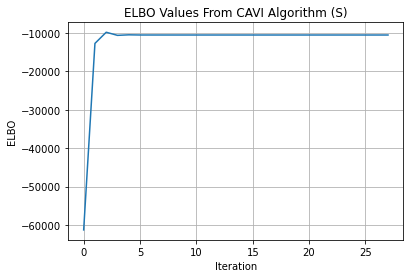

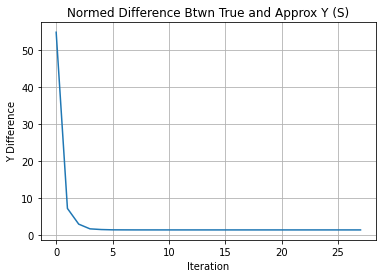

ValueError: x and y must be the same size

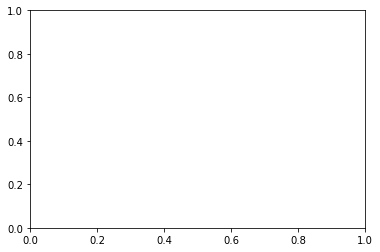

In [8]:
specified_model.plot_elbo()
specified_model.plot_y_diff()
specified_model.plot_approx_data()
specified_model.plot_mse()

In [14]:
class misspecified_model(object):
    def __init__(self, y, t, params, seed=1235):
        self.y = y; self.t = t
        self.params = params
        
    def init_q_params(self):
        '''
        Initialize the parameters of our approximation density q: m_nu, m_gamma, s_nu, s_gamma.
        B/c of our mean field assumption, our covariance matricies s_nu and s_gamma are only
        defined on their diagonals. We store their diagonal values only in s_nu and s_gamma.
        '''
        self.m_nu = np.repeat(np.mean(self.y), self.params.A)
        self.s_nu = np.repeat(np.cov(self.y.T), self.params.A)
        
    def get_elbo(self):
        '''
        Use hierarchy of variables. We have terms which are made up of expressions 
        which are made of parts. We use the variables ti, ei, and pi respectively for
        the i-ith term, expression, and part
        '''

        e1 = self.y.squeeze() - (self.t @ self.m_nu)
        e2 = np.sum(np.power(e1, 2))
        t1 = -0.5 * (self.params.alpha / self.params.epsilon_var) * e2

        e4 = np.power(self.m_nu - self.params.nu_mean, 2)
        t2 = -0.5 * (self.params.nu_cov_diag_inv.T @ e4)
        return t1 + t2
    
    def update_cov_approx(self):
        # update s nu
        e1 = np.sum(np.power(self.t, 2), axis=0)
        e2 = (self.params.alpha / self.params.epsilon_var) * e1
        self.s_nu = 1 / (self.params.nu_cov_diag_inv + e2)

    def update_mean_approx(self):
        # copied from update_cov_approx() function
        e1 = np.sum(np.power(self.t, 2), axis=0)
        e2 = (self.params.alpha / self.params.epsilon_var) * e1
        t1 = (self.params.nu_cov_diag_inv + e2)

        # update m nu
        p1 = self.y.squeeze() - (self.t @ self.m_nu)
        p2 = np.sum(self.t * p1[:, np.newaxis], axis=0) # correct?
        p3 = np.sum(np.power(self.t,2), axis=0) * self.m_nu
        e3 = (self.params.alpha / self.params.epsilon_var) * (p2 + p3)
        e4 = self.params.nu_cov_diag_inv * self.params.nu_mean
        self.m_nu = (e3 + e4) / t1

    def generate_approx_data(self, **kwargs):
        n_input = self.params.n
        for key in kwargs.keys():
            if key == 'n':
                n_input = kwargs[key]

        # sample nu with variational approximations of mean and cov
        rng = default_rng(self.params.seed)
        nu_approx = rng.multivariate_normal(self.m_nu, np.diag(self.s_nu))
      
        # compute y_i = nu*t_i + epsilon_i
        y = (nu_approx[np.newaxis,:] @ np.transpose(self.t[:n_input, :])) + self.params.epsilon[:n_input]
        return y.T # transpose y to make dimensions work
    
    def calc_y_diff(self):
        approx_y = self.generate_approx_data()
        return norm(self.y - approx_y)

    def plot_elbo(self):
        plt.title('ELBO Values From CAVI Algorithm (MS)')
        plt.xlabel('Iteration')
        plt.ylabel('ELBO')
        plt.grid(True)
        plt.plot(self.elbo)
        plt.savefig('plots/ELBO_Values_From_CAVI_Algorithm_(MS).png')
        plt.show()
    
    def plot_y_diff(self):
        plt.plot(self.y_diff)
        plt.title('Normed Difference Btwn True and Approx Y (MS)')
        plt.xlabel('Iteration')
        plt.ylabel('Y Difference')
        plt.grid(True)
        plt.savefig('plots/Normed_Difference_Btwn_True_and_Approx_Y_(MS).png')
        plt.show()

    def plot_approx_data(self):
        '''
        Only plot a small number of data points b/c otherwise plot gets too messy
        '''
        small_n = 30
        x = np.arange(small_n)
        approx_y = self.generate_approx_data(n=small_n)

        x_coords = np.array([x,x])
        y_coords = np.array([self.y[:small_n], approx_y]).squeeze()
        
        # plot the approx data
        plt.scatter(x, self.y[:small_n], marker='o', facecolors='none', edgecolors='r') # plot true y data pts
        plt.scatter(x, approx_y, marker='s', facecolors='none', edgecolors='g') # plot approx y data pts
        plt.xlabel('Data Point Number')
        plt.ylabel('Y Value')
        plt.grid(True)
        plt.legend(['True Y', 'Approx Y'])
        plt.plot(x_coords, y_coords, color='black') # plot lines btwn true y and approx y
        plt.title('True Y Values and Approximate Y Values (MS)')
        plt.savefig('plots/True_Y_Values_and_Approximate_Y_Values_(MS).png')
        plt.show()
    
    def plot_mse(self):
        plt.plot(self.nu_mse)
        plt.legend(['Nu MSE'])
        plt.xlabel('Iteration')
        plt.ylabel('Mean Squared Error')
        plt.title('MSE of Gamma Approximations (MS)')
        plt.grid(True)
        plt.savefig('plots/MSE_of_Nu_Approximations_(MS).png')
        plt.show()
    
    def get_nu_mse(self):
        return mse(self.m_nu, self.params.nu_mean)
    
    def fit(self, max_iter=200, tol=1e-8, printing=True):
        self.init_q_params() # initialize q parameters
        self.update_cov_approx() # update approx of cov
        self.elbo = [self.get_elbo()] # init and create list to store elbo values
        
        # collect stats about model performance
        self.y_diff = [self.calc_y_diff()] # list to store diff btwn true y and approx y
        self.nu_mse = [self.get_nu_mse()] # mse btwn true nu mean and approx nu mean

        for i in range(max_iter):
            # print elbo
            if i % 3 == 0 and printing:
                print(f'ELBO at {i}:\t{self.elbo[-1]}')
            
            self.update_mean_approx() # update parameters
            self.elbo.append(self.get_elbo()) # calc new EBLO

            # collect stats about model performance
            self.y_diff.append(self.calc_y_diff()) # calc new y diff
            self.nu_mse.append(self.get_nu_mse()) # calc new nu mse

            # check for convergence
            diff = np.abs(self.elbo[-1] - self.elbo[-2])
            if diff < tol:
                if printing:
                    print('ELBO converged with %.3f at iteration %d'%(self.elbo[-1], i))
                return

        if printing:
            print('ELBO ended with %.3f after %d iterations'%(self.elbo[-1], max_iter))

In [10]:
misspecified_model = misspecified_model(y,t, params)
misspecified_model.fit()

ELBO at 0:	-528.2399089733744
ELBO at 3:	-197.27963502303174
ELBO at 6:	-196.52863696534794
ELBO at 9:	-196.52693283912186
ELBO at 12:	-196.5269289722061
ELBO converged with -196.527 at iteration 12


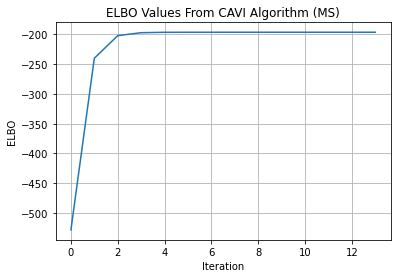

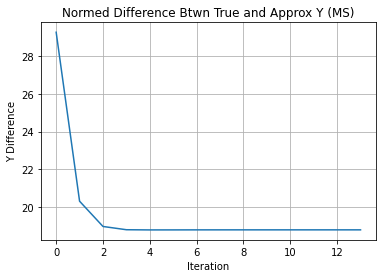

ValueError: x and y must be the same size

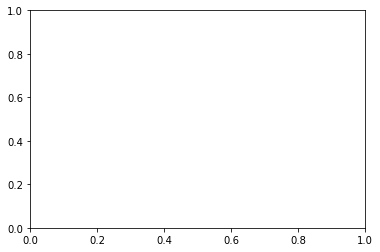

In [11]:
misspecified_model.plot_elbo()
misspecified_model.plot_y_diff()
misspecified_model.plot_approx_data()
misspecified_model.plot_mse()

In [12]:
def generate_kl_data(params, seed=1234):
    #------- Sample from relevant densities ---------------
    rng = default_rng(seed) # pass seed value to default random number generator
    nu = rng.multivariate_normal(params.nu_mean, np.diag(params.nu_cov_diag)) # sample nu from multivariate normal w/ diagonal covar matrix
    gamma = rng.multivariate_normal(params.gamma_mean, np.diag(params.gamma_cov_diag)) # sample gamma from multivariate normal w/ diagonal covar matrix
    assert(gamma.any() != 0) # Some element of gamma must not == 0, otherwise there's no misspecification
    t = rng.multivariate_normal(params.t_mean, params.t_cov, params.n) # sample t from multivariate normal density 
    r = rng.multivariate_normal(params.r_mean, params.r_cov, params.n) # sample r from multivariate normal density
    epsilon = rng.normal(params.epsilon_mean, params.epsilon_var, params.n) # Must be independent of t and x

    params.epsilon = epsilon # hack to get access to epsilon value
    
    #------------ Create data from samples ----------------
    # combine samples in vectorized form, calculating y = nu*t_i + gamma*r_i + epsilon_i
    y = np.matmul(nu[np.newaxis,:], np.transpose(t)) # nu * t
    y += np.matmul(gamma[np.newaxis,:], np.transpose(r)) # gamma * r
    y += epsilon # epsilon
    return y.T, t, r, nu, gamma # transpose y to make dimensions work

def calc_true_posterior(y, t, r, nu, gamma, params):
    tp_dict = {}

    # calculate true posterior for nu
    t1 = (t.T @ y) / (params.n * params.epsilon_var)
    t1 += (params.nu_mean / (params.n * params.nu_cov_diag[0]))[:, np.newaxis] # [a, 1]
    t2 = np.sum(t **2) / (params.n * params.epsilon_var)
    t2 += np.eye(params.A) / (params.n * params.nu_cov_diag[0])
    t2_inv = inv(t2)

    tp_dict['nu_posterior_mean'] = t2_inv @ t1
    tp_dict['nu_posterior_cov'] = params.n * t2_inv

    # calc true posterior for gamma
    t3 = (r.T @ y) / (params.n * params.epsilon_var)
    t3 += (params.gamma_mean / (params.n * params.gamma_cov_diag[0]))[:, np.newaxis] # [b, 1]
    t4 = np.sum(r **2) / (params.n * params.epsilon_var)
    t4 += np.eye(params.B) / (params.n * params.gamma_cov_diag[0])
    t4_inv = inv(t4)

    tp_dict['gamma_posterior_mean'] = t4_inv @ t3
    tp_dict['gamma_posterior_cov'] = params.n * t4_inv

    return tp_dict

def calc_kl_ms(ms_params, tp_dict):
    mean1 = ms_params[0]
    cov1 = np.diag(ms_params[1])
    mean2 = tp_dict['nu_posterior_mean']
    cov2 = tp_dict['nu_posterior_cov']

    cov2_inv = inv(cov2)
    t1 = np.log(det(cov2) / det(cov1))
    t2 = np.trace(cov2_inv @ cov1)
    t3 = (mean2 - mean1).T @ cov2_inv @ (mean2 - mean1)
    t4 = mean1.shape[0]
    ans = 0.5 * (t1 + t2 + t3 - t4)
    return ans.squeeze()
    
def calc_kl_s(s_params, tp_dict):
    mean1 = np.vstack((s_params[0], s_params[2]))
    t1 = np.diag(s_params[1])[:, np.newaxis]
    t2 = np.diag(s_params[3])[:, np.newaxis]
    cov1 = np.diag(np.vstack((t1, t2)).squeeze())
    mean2 = np.vstack((tp_dict['nu_posterior_mean'], 
                        tp_dict['gamma_posterior_mean']))
    t3 = np.diag(tp_dict['nu_posterior_cov'])[:, np.newaxis]
    t4 = np.diag(tp_dict['gamma_posterior_cov'])[:, np.newaxis]
    cov2 = np.diag(np.vstack((t3, t4)).squeeze())
    

    cov2_inv = inv(cov2)
    t1 = np.log(det(cov2) / det(cov1))
    t2 = np.trace(cov2_inv @ cov1)
    t3 = (mean2 - mean1).T @ cov2_inv @ (mean2 - mean1)
    t4 = mean1.shape[0]
    ans = 0.5 * (t1 + t2 + t3 - t4)
    return ans.squeeze()

#@lru_cache()
def kl_divergence(alpha_num=10):
    '''
    tp = true posterior
    ap = approximate posterior, specifically the tempered variational approximation 
            to misspecified model
    '''
    kl_dict_s = {}
    kl_dict_ms = {}
    mse_nu_dict = {}
    y_norm_dict = {}

    params = Parameters(n=1000)
    y, t, r, nu, gamma = generate_kl_data(params)
    
    # generate true model
    tp_dict = calc_true_posterior(y,t,r,nu,gamma,params)
    
    print(params.nu_mean)
    # don't start alpha value at 0 b/c messes up calculations
    for alpha in np.linspace(0,1,alpha_num):
        params.alpha = alpha # set alpha value

        # generate approximate model
        ms_model = misspecified_model(y,t, params)
        ms_model.fit(printing=False)
        ms_params = [ms_model.m_nu[:, np.newaxis], ms_model.s_nu]

        # generate true specified model
        s = specified_model(y, t, r, params)
        s.fit()
        s_params = [s.m_nu[:, np.newaxis], np.diag(s.s_nu),
                    s.m_gamma[:, np.newaxis], np.diag(s.s_gamma)]

        # calc and store kl divergence value
        kl_dict_ms[alpha] = calc_kl_ms(ms_params, tp_dict)
        kl_dict_s[alpha] = calc_kl_s(s_params, tp_dict)

        # calc and store nu mse
        mse_nu_dict[alpha] = ms_model.get_nu_mse()

        # calc and store y diff
        y_norm_dict[alpha] = ms_model.calc_y_diff()
        
        # printing
        alpha_print = "{:.3f}".format(alpha)
        print(alpha_print, ':\t', ms_model.m_nu, mse(ms_model.m_nu, params.nu_mean),
              '\t', s.m_nu, mse(s.m_nu, params.nu_mean))


    return kl_dict_s, kl_dict_ms, mse_nu_dict, y_norm_dict

def graph_kl(kl_dict):
    lists = sorted(kl_dict.items()) # sorted by key, return a list of tuples
    alpha, kl_val = zip(*lists) # unpack a list of pairs into two tuples

    plt.plot(alpha, kl_val)
    plt.xlabel('Alpha')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence W/ Diff Alpha Values')
    plt.grid(True)
    #plt.yscale('log')
    plt.savefig('plots/Alpha_KL_Divergence.png')
    plt.show()

def graph_nu_mse(nu_mse_dict):
    ########## investigate here #############
    lists = sorted(nu_mse_dict.items()) # sorted by key, return a list of tuples
    alpha, nu_mse_val = zip(*lists) # unpack a list of pairs into two tuples

    plt.plot(alpha, nu_mse_val)
    plt.xlabel('Alpha')
    plt.ylabel('MSE Btwn Nu and Nu Approx in MS Model')
    plt.title('Nu Mean Squared Error W/ Diff Alpha Values')
    plt.grid(True)
    plt.savefig('plots/Alpha_Nu_MSE.png')
    plt.show()

def graph_y_norm(y_norm_dict):
    lists = sorted(y_norm_dict.items()) # sorted by key, return a list of tuples
    alpha, y_norm_val = zip(*lists) # unpack a list of pairs into two tuples

    plt.plot(alpha, y_norm_val)
    plt.title('Normed Difference Btwn True and Approx Y for Diff Alpha Values (MS)')
    plt.xlabel('Alpha')
    plt.ylabel('Y Difference')
    plt.grid(True)
    plt.savefig('plots/Alpha_Y_Norm.png')
    plt.show()

In [16]:
kl_s, kl_ms, nu_mse_results, y_norm_results = kl_divergence(alpha_num=11)

[4.783409 9.332824]
ELBO at 0:	-849.9541493062413
ELBO converged with -2.000 at iteration 1
0.000 :	 [4.783409 9.332824] 3.944304526105059e-31 	 [4.783409 9.332824] 3.944304526105059e-31
ELBO at 0:	-32176959.902369976
ELBO converged with -7917416.264 at iteration 11
0.100 :	 [3.771536 9.411946] 0.5150736798855272 	 [3.943297 9.36918 ] 0.353554982261087
ELBO at 0:	-64353069.850590646
ELBO converged with -15824953.340 at iteration 12
0.200 :	 [3.757183 9.412467] 0.5297418408939539 	 [3.931227 9.369235] 0.3637698335124149
ELBO at 0:	-96529179.79881133
ELBO converged with -23732386.306 at iteration 12
0.300 :	 [3.752307 9.412641] 0.5347709372260123 	 [3.927127 9.369251] 0.36727335079039636
ELBO at 0:	-128705289.74703199
ELBO converged with -31639792.669 at iteration 12
0.400 :	 [3.749852 9.412727] 0.5373124314327548 	 [3.925061 9.369258] 0.3690441266669129
ELBO at 0:	-160881399.69525266
ELBO converged with -39547188.296 at iteration 13
0.500 :	 [3.748373 9.412779] 0.5388460495180958 	 [3.9

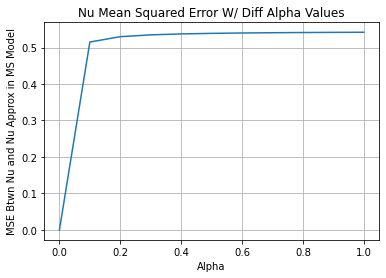

In [17]:
graph_nu_mse(nu_mse_results)

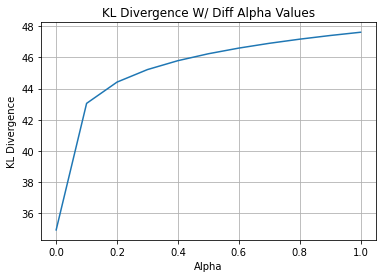

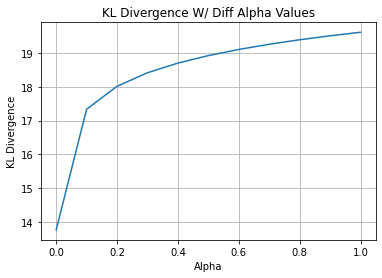

In [18]:
graph_kl(kl_s)
graph_kl(kl_ms)

# Computing KL Divergence

* draw $100$ samples of $\alpha \sim U[0,1]$:
    * draw $n$ samples of $x \sim U[-\infty, \infty]$. Then, on these data points:
        * calculate true posterior
        * calculate the alpha posterior of the misspecified model
        * calculate the variational approximation of the true posterior
        * calculate variational approximation of the alpha posterior of the misspecified model
        * compute the $KL$-divergence between these distributions

<p> Note that the KL-divergence that we care most about is (1) from the variational approximation of the misspecified alpha posterior to the true posterior (for the best performing alpha value) and (2) from the variational approximation of the misspecified true posterior to the true posterior (i.e. when alpha=1). We want to show that the former performs better than the latter. Now we break down a couple of the steps more in depth </p>

* calculate the true posterior $y_i = \nu^T t_i + \gamma^T r_i + \epsilon_i$. It's probability is given by:

$p(y_i|\nu, \gamma, t_i, r_i) \sim \mathcal{N}(\nu^T t_i + \gamma^T r_i, \sigma_\epsilon^2) = (2 \pi \sigma_\epsilon^2)^{- \frac{1}{2}} \exp \bigg( - \frac{\big(y_i - \nu^T t_i - \gamma^T r_i\big)^2}{2 \sigma_\epsilon^2} \bigg)$
    
* calculate the variational approximation of the misspecified alpha posterior $(y_i)_\textrm{approx}^\alpha = (\nu_{\textrm{approx}}^\alpha)^T t_i + \epsilon_i$. It's probability is given by:

$p((y_i)_{\textrm{approx}}^\alpha | \nu_{\textrm{approx}}^\alpha, t_i) \sim \mathcal{N}((\nu_{\textrm{approx}}^\alpha)^T t_i, \sigma_\epsilon^2) = (2 \pi \sigma_\epsilon^2)^{- \frac{1}{2}} \exp \bigg( - \frac{\big((y_i)_{\textrm{approx}}^\alpha - (\nu_{\textrm{approx}}^\alpha)^T t_i\big)^2}{2 \sigma_\epsilon^2} \bigg)$

In [173]:
def approx_alpha_posterior(nu, misspecified_m_nu, misspecified_s_nu):
    return multivariate_normal(nu, misspecified_m_nu, misspecified_s_nu)

def calc_true_likelihood(y, nu, gamma, t, r, sigma2):
    pshape(nu); pshape(t)
    mean = (t @ nu) + (r @ gamma)
    var = sigma2
    return np.sum(multivariate_normal.logpdf(y, mean, var))

def calc_true_prior(nu, gamma, params):
    mean1 = params.nu_mean
    mean2 = params.gamma_mean
    cov1 = np.diag(params.nu_cov_diag) + 1e-8 * np.eye(mean1.size)
    cov2 = np.diag(params.gamma_cov_diag) + 1e-8 * np.eye(mean2.size)

    pdf1 = multivariate_normal.logpdf(nu, mean1, cov1)
    pdf2 = multivariate_normal.logpdf(gamma, mean2, cov2)
    return pdf1 + pdf2

def fn(nu, gamma, y, t, r, sigma2, params):
    # args include the follwoing variables: y, t, r, sigma2, params
    log_likelihood = calc_true_likelihood(y, nu, gamma, t, r, sigma2)
    log_prior = calc_true_prior(nu, gamma, params)
    return np.exp(log_likelihood + log_prior)

def calc_true_normalizing(y, t, r, sigma2, params): 
    n = 3; m = 3
    A = t.shape[1]; B = r.shape[1]
    rng = default_rng(seed=1234)
    integral = 0
    for i in range(n):
        for j in range(m):
            nu_i = rng.uniform(low=-10000, high=10000, size=A)
            gamma_j = rng.uniform(low=-10000, high=10000, size=B)    
            integral += fn(nu_i, gamma_j, y, t, r, sigma2, params)
    return np.log(integral)

def true_log_posterior(y, nu, gamma, t, r, sigma2, params):
    true_likelihood = calc_true_likelihood(y, nu, gamma, t, r, sigma2)
    true_prior = calc_true_prior(nu, gamma, params)
    #true_normalizing = calc_true_normalizing(y, t, r, sigma2, params)
    true_normalizing = 1
    return true_prior + true_likelihood - true_normalizing

def calc_kl(kl_dict, seed):
    '''
    calc kl divergence from variational approximation of misspecified alpha posterior
    to the true posterior i.e. calculate KL(P || Q) where P = variational approx of misspecified alpha posterior and Q = true posterior
    '''

    # unpack parameters
    nu = kl_dict['nu']; gamma = kl_dict['gamma']
    nu_approx = kl_dict['nu_approx']
    t = kl_dict['t']; r = kl_dict['r']
    y = kl_dict['y']; sigma2 = kl_dict['sigma2']
    alpha = kl_dict['alpha']; params = kl_dict['params']
    misspecified_m_nu = kl_dict['MS m nu']
    misspecified_s_nu  = kl_dict['MS s nu']

    kl = 0
    rng = default_rng(seed)
    A = t.shape[0]; B = r.shape[0]
    n = 3; m = 3
    # compute kl divergence
    for i in range(n):
        for j in range(m):
            nu_i = rng.uniform(low=-10000, high=10000, size=A)
            gamma_j = rng.uniform(low=-10000, high=10000, size=B)

            log_p = true_log_posterior(y, nu_i, gamma_j, t, r, sigma2, params)
            q = approx_alpha_posterior(nu_i, misspecified_m_nu, misspecified_s_nu)
            kl += q * (np.log(q) - log_p)
    
    return kl

def generate_kl_data(params, seed=1234):
    #------- Sample from relevant densities ---------------
    rng = default_rng(seed) # pass seed value to default random number generator
    nu = rng.multivariate_normal(params.nu_mean, np.diag(params.nu_cov_diag)) # sample nu from multivariate normal w/ diagonal covar matrix
    gamma = rng.multivariate_normal(params.gamma_mean, np.diag(params.gamma_cov_diag)) # sample gamma from multivariate normal w/ diagonal covar matrix
    assert(gamma.any() != 0) # Some element of gamma must not == 0, otherwise there's no misspecification
    t = rng.multivariate_normal(params.t_mean, params.t_cov, params.n) # sample t from multivariate normal density 
    r = rng.multivariate_normal(params.r_mean, params.r_cov, params.n) # sample r from multivariate normal density
    epsilon = rng.normal(params.epsilon_mean, params.epsilon_var, params.n) # Must be independent of t and x

    params.epsilon = epsilon # hack to get access to epsilon value
    
    #------------ Create data from samples ----------------
    # combine samples in vectorized form, calculating y = nu*t_i + gamma*r_i + epsilon_i
    y = np.matmul(nu[np.newaxis,:], np.transpose(t)) # nu * t
    y += np.matmul(gamma[np.newaxis,:], np.transpose(r)) # gamma * r
    y += epsilon # epsilon
    return y.T, t, r, nu, gamma # transpose y to make dimensions work

def create_model(alpha):
    params = Parameters(n=1000, alpha=alpha)
    y, t, r, nu, gamma = generate_kl_data(params)

    # generate and fit misspecified model
    misspecified = misspecified_model(y,t, params)
    misspecified.fit(printing=False)
    nu_approx = default_rng(seed=123).multivariate_normal(misspecified.m_nu, np.diag(misspecified.s_nu))

    # store relevant params in dict
    kl_dict = {'nu': nu,
            'gamma': gamma,
            'nu_approx': nu_approx,
            't': t,
            'r': r,
            'y': y,
            'alpha': alpha,
            'sigma2': params.epsilon_var,
            'MS m nu': misspecified.m_nu,
            'MS s nu': np.diag(misspecified.s_nu),
            'params': params}
    return kl_dict

def main(seed=123):
    rng = default_rng(seed)
    n_alpha = 100; n = 10000
    min = np.finfo(np.float32).min; max = np.finfo(np.float32).max

    kl_results = {} # dict to store alpha and kl values
    #alpha = np.linspace(1e-8,1, n_alpha) # 100 alpha values btwn [0,1]
    alpha = np.linspace(-10, 100, n_alpha)
    for a in alpha: # loop over all alpha values
        kl_dict = create_model(a) # create appropriate models w/ given alpha
        kl_results[a] = calc_kl(kl_dict, seed=seed) # actually compute kl divergence
        break

    #plot_kl(kl_results)
    #min_alpha = kl_comparison(kl_results)
    return kl_results

In [174]:
kl_results = main()

(1000,)
(1000,)
(1000, 2)
ipykernel_launcher:58: RuntimeWarning: covariance is not positive-semidefinite.
ipykernel_launcher:103: RuntimeWarning: covariance is not positive-semidefinite.


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 2)

In [ ]:
def kl_comparison(kl_results):
    min_alpha = list(kl_results.items())[0][0] # access first key
    min_kl = kl_results[min_alpha] # access the first value
    
    for k, v in kl_results.items():
        if v < min_kl:
            print(k)
            min_alpha = k
            min_kl = v
    
    try:
        diff = kl_results[1] - min_kl
        print(f'Diff is {diff} with alpha = {min_alpha}')
    except:
        print('no value at 1')
    return min_alpha

def plot_kl(kl_results):
    plt.grid(True)
    plt.xlabel('Alpha')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence from Variational Approximation of Misspecified Alpha Posterior to True Posterior')
    plt.plot(*zip(*sorted(kl_results.items())))
    plt.show()

In [ ]:
normalizing, err = dblquad(fn, -np.infty, np.infty, 
                                lambda gamma: -np.infty,
                                lambda gamma: np.infty,
                                args=(y, t, r, sigma2, params))

# My Analysis of KL-Divergence Results

<p> Currently the only reason the variational approximation with alpha performs better than the alpha posterior without alpha (or when alpha=1) is b/c of a one-off fluke that alpha=1e-8 gets a lower KL-divergence, but all other values of alpha actually result in a higher KL-divergence. Seems to me that I need to first fix the misspecified model code and then this problem will be fixed. </p>

<p> Also, if I have time, edit the clipping function to have the biggest range possible before clipping. Currently, the range is [-500, 500]. See if I can make it bigger </p>